# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum.

## Helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


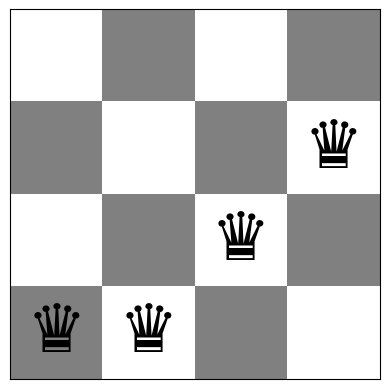

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [4]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


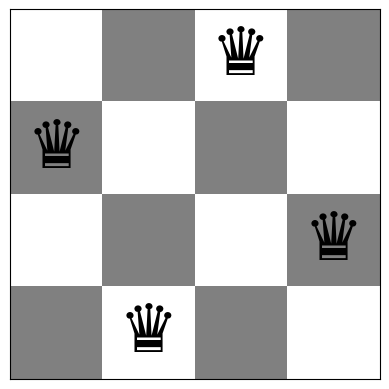

In [5]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum.

In [6]:
def steepest_ascend_hill_climbing(initial_board):

    current_board = list(initial_board)
    n = len(current_board)
    steps = 0

    while True:
        current_conflicts = conflicts(current_board)
        best_neighbor = list(current_board)
        best_conflicts = current_conflicts

        # Explore all possible local moves
        for col in range(n):
            for row in range(n):
                if current_board[col] != row:
                    neighbor_board = list(current_board)
                    neighbor_board[col] = row
                    neighbor_conflicts = conflicts(neighbor_board)

                    # If a neighbor has fewer conflicts, update best_neighbor
                    if neighbor_conflicts < best_conflicts:
                        best_conflicts = neighbor_conflicts
                        best_neighbor = neighbor_board

        # If no neighbor improves the situation, we are at a local optimum
        if best_conflicts >= current_conflicts:
            return current_board, current_conflicts, steps
        else:
            current_board = best_neighbor
            steps += 1

# n = 8
# initial_board = random_board(n)
# final_board, final_conflicts, steps = steepest_ascend_hill_climbing(initial_board)
# print(f"Initial conflicts: {conflicts(initial_board)}")
# print(f"Final conflicts: {final_conflicts}")
# print(f"Steps taken: {steps}")
# show_board(final_board)

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [7]:
import random

def stochastic_hill_climbing_1(initial_board):

    current_board = list(initial_board)
    n = len(current_board)
    steps = 0

    while True:
        current_conflicts = conflicts(current_board)
        uphill_moves = []

        # Find all uphill moves
        for col in range(n):
            for row in range(n):
                if current_board[col] != row:
                    neighbor_board = list(current_board)
                    neighbor_board[col] = row
                    neighbor_conflicts = conflicts(neighbor_board)

                    if neighbor_conflicts < current_conflicts:
                        uphill_moves.append(neighbor_board)

        # If there are no uphill moves, we are at a local optimum
        if not uphill_moves:
            return current_board, current_conflicts, steps
        else:
            # Choose a random uphill move
            current_board = random.choice(uphill_moves)
            steps += 1

# n = 8
# initial_board = random_board(n)
# final_board, final_conflicts, steps = stochastic_hill_climbing_1(initial_board)
# print(f"Initial conflicts: {conflicts(initial_board)}")
# print(f"Final conflicts: {final_conflicts}")
# print(f"Steps taken: {steps}")
# show_board(final_board)

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [8]:
import random

def stochastic_hill_climbing_2(initial_board, max_tries_without_improvement=1000):

    current_board = list(initial_board)
    n = len(current_board)
    steps = 0
    tries_without_improvement = 0

    while tries_without_improvement < max_tries_without_improvement:
        current_conflicts = conflicts(current_board)
        improved = False

        # Generate a single random local neighbor
        col = random.randint(0, n - 1)
        row = random.randint(0, n - 1)

        # Ensure the move is different from the current position
        if current_board[col] != row:
            neighbor_board = list(current_board)
            neighbor_board[col] = row
            neighbor_conflicts = conflicts(neighbor_board)

            # If the neighbor is better, accept it
            if neighbor_conflicts < current_conflicts:
                current_board = neighbor_board
                steps += 1
                improved = True
                tries_without_improvement = 0 # Reset counter
            else:
                tries_without_improvement += 1
        else:
             tries_without_improvement += 1 # Still a try without improvement if the random move is the same

        # Check if we've reached a solution
        if conflicts(current_board) == 0:
            return current_board, 0, steps


    # If the loop finishes, we've likely reached a local optimum or max tries reached
    return current_board, conflicts(current_board), steps

# n = 8
# initial_board = random_board(n)
# final_board, final_conflicts, steps = stochastic_hill_climbing_2(initial_board)
# print(f"Initial conflicts: {conflicts(initial_board)}")
# print(f"Final conflicts: {final_conflicts}")
# print(f"Steps taken: {steps}")
# show_board(final_board)

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [9]:
def hill_climbing_with_restarts(hill_climbing_algo, n, num_restarts=100):

    best_board = None
    best_conflicts = float('inf')
    total_steps = 0
    restarts_performed = 0

    for _ in range(num_restarts):
        restarts_performed += 1
        initial_board = random_board(n)
        final_board, final_conflicts, steps = hill_climbing_algo(initial_board)

        total_steps += steps

        if final_conflicts < best_conflicts:
            best_conflicts = final_conflicts
            best_board = final_board

        # If an optimal solution is found, we can stop early
        if best_conflicts == 0:
            break

    return best_board, best_conflicts, total_steps, restarts_performed

# Example usage with Steepest Ascend Hill Climbing:
# n = 8
# best_board_sa, best_conflicts_sa, total_steps_sa, restarts_sa = hill_climbing_with_restarts(steepest_ascend_hill_climbing, n)
# print(f"Steepest Ascend HC with Restarts:")
# print(f"Best conflicts found: {best_conflicts_sa}")
# print(f"Total steps: {total_steps_sa}")
# print(f"Restarts performed: {restarts_sa}")
# if best_conflicts_sa == 0:
#     print("Optimal solution found!")
#     show_board(best_board_sa)
# else:
#     print("Optimal solution not found.")


# Example usage with Stochastic Hill Climbing 1:
# n = 8
# best_board_shc1, best_conflicts_shc1, total_steps_shc1, restarts_shc1 = hill_climbing_with_restarts(stochastic_hill_climbing_1, n)
# print(f"\nStochastic HC 1 with Restarts:")
# print(f"Best conflicts found: {best_conflicts_shc1}")
# print(f"Total steps: {total_steps_shc1}")
# print(f"Restarts performed: {restarts_shc1}")
# if best_conflicts_shc1 == 0:
#     print("Optimal solution found!")
#     show_board(best_board_shc1)
# else:
#     print("Optimal solution not found.")

# Example usage with Stochastic Hill Climbing 2:
# n = 8
# best_board_shc2, best_conflicts_shc2, total_steps_shc2, restarts_shc2 = hill_climbing_with_restarts(stochastic_hill_climbing_2, n)
# print(f"\nStochastic HC 2 with Restarts:")
# print(f"Best conflicts found: {best_conflicts_shc2}")
# print(f"Total steps: {total_steps_shc2}")
# print(f"Restarts performed: {restarts_shc2}")
# if best_conflicts_shc2 == 0:
#     print("Optimal solution found!")
#     show_board(best_board_shc2)
# else:
#     print("Optimal solution not found.")

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

In [10]:
import random
import math
import matplotlib.pyplot as plt

def simulated_annealing(initial_board, initial_temperature=100, cooling_rate=0.95, max_iterations=10000):

    current_board = list(initial_board)
    n = len(current_board)
    temperature = initial_temperature
    conflicts_history = [conflicts(current_board)]

    for i in range(max_iterations):
        current_conflicts = conflicts(current_board)

        if current_conflicts == 0:
            conflicts_history.append(current_conflicts)
            break

        # Generate a random neighbor
        col = random.randint(0, n - 1)
        row = random.randint(0, n - 1)

        neighbor_board = list(current_board)
        neighbor_board[col] = row
        neighbor_conflicts = conflicts(neighbor_board)

        # Calculate the change in conflicts
        delta_conflicts = neighbor_conflicts - current_conflicts

        # Accept the neighbor if it's better or with a certain probability
        if delta_conflicts < 0 or random.random() < math.exp(-delta_conflicts / temperature):
            current_board = neighbor_board

        # Decrease the temperature
        temperature *= cooling_rate

        conflicts_history.append(conflicts(current_board))

    return current_board, conflicts(current_board), conflicts_history

# Function to plot the conflicts history
def plot_conflicts_history(conflicts_history):
    """Plots the number of conflicts over iterations."""
    plt.figure(figsize=(10, 6))
    plt.plot(conflicts_history)
    plt.xlabel("Iterations")
    plt.ylabel("Number of Conflicts")
    plt.title("Simulated Annealing: Conflict Reduction Over Time")
    plt.grid(True)
    plt.show()

# n = 8
# initial_board = random_board(n)
# final_board_sa, final_conflicts_sa, conflicts_hist_sa = simulated_annealing(initial_board)
# print(f"Initial conflicts: {conflicts(initial_board)}")
# print(f"Final conflicts: {final_conflicts_sa}")
# print(f"Steps taken: {len(conflicts_hist_sa) - 1}")
# show_board(final_board_sa)
# plot_conflicts_history(conflicts_hist_sa)

## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [11]:
import time

# Define the algorithms to test
algorithms = {
    "Steepest asc. HC": steepest_ascend_hill_climbing,
    "Stochastic HC 1": stochastic_hill_climbing_1,
    "Stochastic HC 2": stochastic_hill_climbing_2,
    "Simulated Annealing": simulated_annealing
}

board_sizes = [4, 8]
num_runs = 100
results = []

for board_size in board_sizes:
    print(f"Running experiments for board size: {board_size}")
    for algo_name, algorithm in algorithms.items():
        print(f"  Running {algo_name}...")
        total_runtime = 0
        total_conflicts = 0
        optimal_solutions = 0

        for _ in range(num_runs):
            initial_board = random_board(board_size)
            start_time = time.time()

            # Need to handle the different return types of simulated_annealing
            if algo_name == "Simulated Annealing":
                final_board, final_conflicts, _ = algorithm(initial_board)
            else:
                final_board, final_conflicts, _ = algorithm(initial_board)

            end_time = time.time()
            runtime = end_time - start_time

            total_runtime += runtime
            total_conflicts += final_conflicts

            if final_conflicts == 0:
                optimal_solutions += 1

        avg_runtime = total_runtime / num_runs
        avg_conflicts = total_conflicts / num_runs
        success_rate = (optimal_solutions / num_runs) * 100

        results.append({
            "Algorithm": algo_name,
            "Board size": board_size,
            "Avg. Run time": avg_runtime,
            "Avg. number of conflicts": avg_conflicts,
            "% of runs ending in optimal solution": success_rate
        })

# Print the results in a table format
print("\nComparison Results:")
print("| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |")
print("| ------------------- | ---------- | ------------- | --------------------------------- | - |")
for row in results:
    print(f"| {row['Algorithm']:<19} | {row['Board size']:<10} | {row['Avg. Run time']:<13.6f} | {row['Avg. number of conflicts']:<33.2f} | {row['% of runs ending in optimal solution']:<35.2f} |")

Running experiments for board size: 4
  Running Steepest asc. HC...
  Running Stochastic HC 1...
  Running Stochastic HC 2...
  Running Simulated Annealing...
Running experiments for board size: 8
  Running Steepest asc. HC...
  Running Stochastic HC 1...
  Running Stochastic HC 2...
  Running Simulated Annealing...

Comparison Results:
| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    | 4          | 0.000140      | 0.53                              | 49.00                               |
| Stochastic HC 1     | 4          | 0.000166      | 0.69                              | 40.00                               |
| Stochastic HC 2     | 4          | 0.011052      | 0.93                              | 25.00                               |
| Simulated Annealing | 4          | 0.001458      | 0.00          

### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

In [12]:
# Code and description go here

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

In [13]:
# Code and description go here

## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

In [14]:
# Code and description go here

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Implement a Genetic Algorithm for the n-Queens problem

In [15]:
# Code and description go here

# Task
Implement and compare the performance of Steepest Ascend Hill Climbing, Stochastic Hill Climbing 1, Stochastic Hill Climbing 2, and Simulated Annealing algorithms for the N-Queens problem. Analyze their convergence behavior and scalability with increasing board size. Present the results in a comparison table and visualizations, and discuss your findings.

## Implement the comparison code

### Subtask:
Write code to run each of the four algorithms (Steepest Ascend HC, Stochastic HC 1, Stochastic HC 2, and Simulated Annealing) for board sizes 4 and 8, multiple times (at least 100). Record the runtime, final number of conflicts, and whether an optimal solution was found for each run.


**Reasoning**:
The subtask requires running each algorithm multiple times for different board sizes and recording the performance metrics. This involves iterating through board sizes, algorithms, and runs, executing the algorithms, and storing the results. A list of dictionaries seems appropriate for storing the results.



**Reasoning**:
The previous code failed because the functions for the hill climbing algorithms were not defined in the current scope. The traceback indicates that `stochastic_hill_climbing_1` is not defined. I need to regenerate the code block including the definitions of all the required functions before using them.

